# A1: Linear Regression - Car Price Prediction
**Student ID: st126010 - Htut Ko Ko**

This notebook implements basic linear regression for car price prediction with proper ML pipeline.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
from LinearRegression import LinearRegression
import pickle
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")

Libraries imported successfully!


In [2]:
# Load and clean data
data = pd.read_csv('Cars.csv')
data['mileage'] = data['mileage'].str.extract('(\\d+\\.?\\d*)').astype(float)
data['engine'] = data['engine'].str.extract('(\\d+)').astype(float)
data['max_power'] = data['max_power'].str.extract('(\\d+\\.?\\d*)').astype(float)
data = data.drop(columns=['name', 'torque'])

print(f"Dataset shape: {data.shape}")
print(f"Missing values: {data.isnull().sum().sum()}")

Dataset shape: (8128, 11)
Missing values: 879


In [3]:
# Define features and target
numeric_columns = ['year', 'km_driven', 'mileage', 'engine', 'max_power', 'seats']
categorical_columns = ['fuel', 'seller_type', 'transmission', 'owner']
feature_names = numeric_columns + categorical_columns

X = data[feature_names].copy()
y = data['selling_price']

print(f"Features: {len(feature_names)} ({len(numeric_columns)} numeric + {len(categorical_columns)} categorical)")

Features: 10 (6 numeric + 4 categorical)


In [4]:
# STEP 1: Split data FIRST
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training set: {X_train.shape}, Test set: {X_test.shape}")

Training set: (6502, 10), Test set: (1626, 10)


In [5]:
# STEP 2: Impute missing values
imputer_num = SimpleImputer(strategy='mean')
imputer_cat = SimpleImputer(strategy='most_frequent')

X_train[numeric_columns] = imputer_num.fit_transform(X_train[numeric_columns])
X_test[numeric_columns] = imputer_num.transform(X_test[numeric_columns])
X_train[categorical_columns] = imputer_cat.fit_transform(X_train[categorical_columns])
X_test[categorical_columns] = imputer_cat.transform(X_test[categorical_columns])

print("✅ Missing values imputed")

✅ Missing values imputed


In [6]:
# STEP 3: Encode categorical variables
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    X_train[col] = le.fit_transform(X_train[col].astype(str))
    X_test[col] = le.transform(X_test[col].astype(str))
    label_encoders[col] = le

print("✅ Categorical variables encoded")

✅ Categorical variables encoded


In [7]:
# STEP 4: Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✅ Features scaled")

✅ Features scaled


In [8]:
# STEP 5: Train model
model = LinearRegression()
model.fit(X_train_scaled, y_train.values)

# Predict and evaluate
y_pred_test = model.predict(X_test_scaled)
test_r2 = model.r2(X_test_scaled, y_test.values)
test_mse = mean_squared_error(y_test, y_pred_test)

print(f"A1 Model Results:")
print(f"R² Score: {test_r2:.4f}")
print(f"MSE: {test_mse:.2f}")

A1 Model Results:
R² Score: 0.6864
MSE: 205528751993.26


In [9]:
# Save model artifacts
model_artifacts = {
    'model': model,
    'scaler': scaler,
    'imputer_num': imputer_num,
    'imputer_cat': imputer_cat,
    'label_encoders': label_encoders,
    'feature_names': feature_names,
    'metrics': {
        'test_r2': test_r2,
        'test_mse': test_mse
    },
    'model_type': 'linear_regression'
}

with open('a1_model_artifacts.pkl', 'wb') as f:
    pickle.dump(model_artifacts, f)

print("✅ A1 model saved")
print(f"🎯 Final R²: {test_r2:.4f}")
print("🔄 Pipeline: Split → Impute → Scale → Train → Evaluate")

✅ A1 model saved
🎯 Final R²: 0.6864
🔄 Pipeline: Split → Impute → Scale → Train → Evaluate


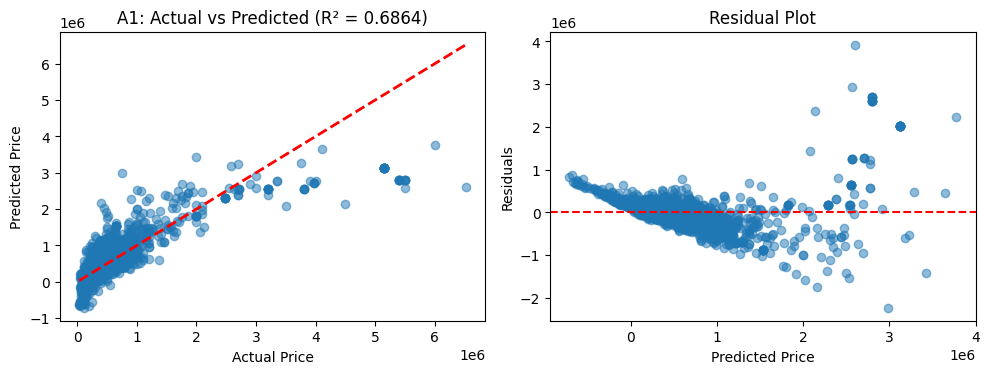


A1 Linear Regression completed successfully!


In [10]:
# Visualize results
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_test, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title(f'A1: Actual vs Predicted (R² = {test_r2:.4f})')

plt.subplot(1, 2, 2)
residuals = y_test - y_pred_test
plt.scatter(y_pred_test, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Price')
plt.ylabel('Residuals')
plt.title('Residual Plot')

plt.tight_layout()
plt.show()

print("\nA1 Linear Regression completed successfully!")